In [1]:
import pandas as pd
import numpy as np
from pandas.api.types import is_object_dtype
from pandas.api.types import is_numeric_dtype
import xgboost as xg
from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings

In [2]:
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
train=pd.read_csv('/home/ivan_pronin/IT/kaggle/optiver2023/optiver-trading-at-the-close/example_test_files/train.csv')
# test=pd.read_csv('/home/ivan_pronin/IT/kaggle/optiver2023/optiver-trading-at-the-close/example_test_files/test.csv')
# revealed_targets=pd.read_csv('/home/ivan_pronin/IT/kaggle/optiver2023/optiver-trading-at-the-close/example_test_files/revealed_targets.csv')
# sample_submission=pd.read_csv('/home/ivan_pronin/IT/kaggle/optiver2023/optiver-trading-at-the-close/example_test_files/sample_submission.csv')

In [4]:
with open('/home/ivan_pronin/IT/kaggle/optiver2023/data_description.txt', 'r') as f:
    lines=f.readlines()
    for line in lines:
        print(line)

stock_id - A unique identifier for the stock. Not all stock IDs exist in every time bucket.

date_id - A unique identifier for the date. Date IDs are sequential & consistent across all stocks.

imbalance_size - The amount unmatched at the current reference price (in USD).

imbalance_buy_sell_flag - An indicator reflecting the direction of auction imbalance.

    buy-side imbalance; 1

    sell-side imbalance; -1

    no imbalance; 0

reference_price - The price at which paired shares are maximized, the imbalance is minimized and the distance from the bid-ask midpoint is minimized, in that order. Can also be thought of as being equal to the near price bounded between the best bid and ask price.

matched_size - The amount that can be matched at the current reference price (in USD).

far_price - The crossing price that will maximize the number of shares matched based on auction interest only. This calculation excludes continuous market orders.

near_price - The crossing price that will ma

In [5]:
train

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


In [6]:
train.dropna(subset=['target'], axis=0, inplace=True)

In [7]:
zero_data_set_sum_train=train.isnull().sum()
zero_data_set_percentage_train=train.isnull().sum()/train.shape[0]*100
zero_data_set_train=pd.DataFrame({'sum':zero_data_set_sum_train, 'percentage': zero_data_set_percentage_train})
zero=zero_data_set_train.loc[zero_data_set_train['sum']>0]

In [8]:
zero

,sum,percentage
imbalance_size,132,0.002520
reference_price,132,0.002520
matched_size,132,0.002520
far_price,2894254,55.256084
near_price,2857092,54.546600
bid_price,132,0.002520
ask_price,132,0.002520
wap,132,0.002520


In [9]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder

for col in zero.index:
    train2=train.copy()
    index_train=train2.loc[train2[col].isna()==False, col].index
    index_test=train2.loc[train2[col].isna()==True, col].index
    train2=train2.loc[:, ~train2.columns.isin(zero.index)]
    train2.drop(columns=['target'], inplace=True)
    y_train=train[col].loc[index_train]
    x_train=train2.loc[index_train]
    x_test=train2.loc[index_test]
    if x_train.shape[0]<6:
        neighbors=x_train.shape[0]
    else:
        neighbors=6
    KNN_reg=KNeighborsRegressor(n_neighbors=neighbors, weights='distance')
    KNN_reg.fit(x_train,y_train)
    predictions=KNN_reg.predict(x_test)
    train.loc[index_test,col] = train.loc[index_test, col].fillna(predictions[0])

In [10]:
train.isna().sum()

stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matched_size               0
far_price                  0
near_price                 0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
target                     0
time_id                    0
row_id                     0
dtype: int64

In [14]:
train.drop(columns=['time_id', 'row_id'], inplace=True)

In [15]:
train

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
0,0,0,0,3180602.69,1,0.999812,13380276.64,1.004781,1.001678,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704
1,1,0,0,166603.91,-1,0.999896,1642214.25,1.004781,1.001678,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986
2,2,0,0,302879.87,-1,0.999561,1819368.03,1.004781,1.001678,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950
3,3,0,0,11917682.27,-1,1.000171,18389745.62,1.004781,1.001678,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200
4,4,0,0,447549.96,-1,0.999532,17860614.95,1.004781,1.001678,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184


In [19]:
train[(train['date_id']==0)&(train['stock_id']==1)].head(7)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
1,1,0,0,166603.91,-1,0.999896,1642214.25,1.004781,1.001678,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986
192,1,0,10,165923.20,-1,0.999955,1642894.96,1.004781,1.001678,0.999896,3743.52,1.000660,33717.42,0.999973,-1.620054
383,1,0,20,165923.20,-1,0.999955,1642894.96,1.004781,1.001678,0.999896,3743.52,1.000660,33717.42,0.999973,-6.459951
574,1,0,30,165923.20,-1,0.999896,1642894.96,1.004781,1.001678,0.999896,4254.00,1.000308,3574.83,1.000120,-5.149841
765,1,0,40,162349.47,-1,0.999955,1646468.69,1.004781,1.001678,0.999896,21270.00,1.000308,3574.83,1.000248,-6.750226
956,1,0,50,155542.37,-1,0.999955,1653275.80,1.004781,1.001678,0.999896,20929.68,1.000308,3574.83,1.000248,-5.949736
1147,1,0,60,175963.68,-1,1.000249,1634726.44,1.004781,1.001678,1.000249,170.22,1.000543,2383.78,1.000268,-4.680157


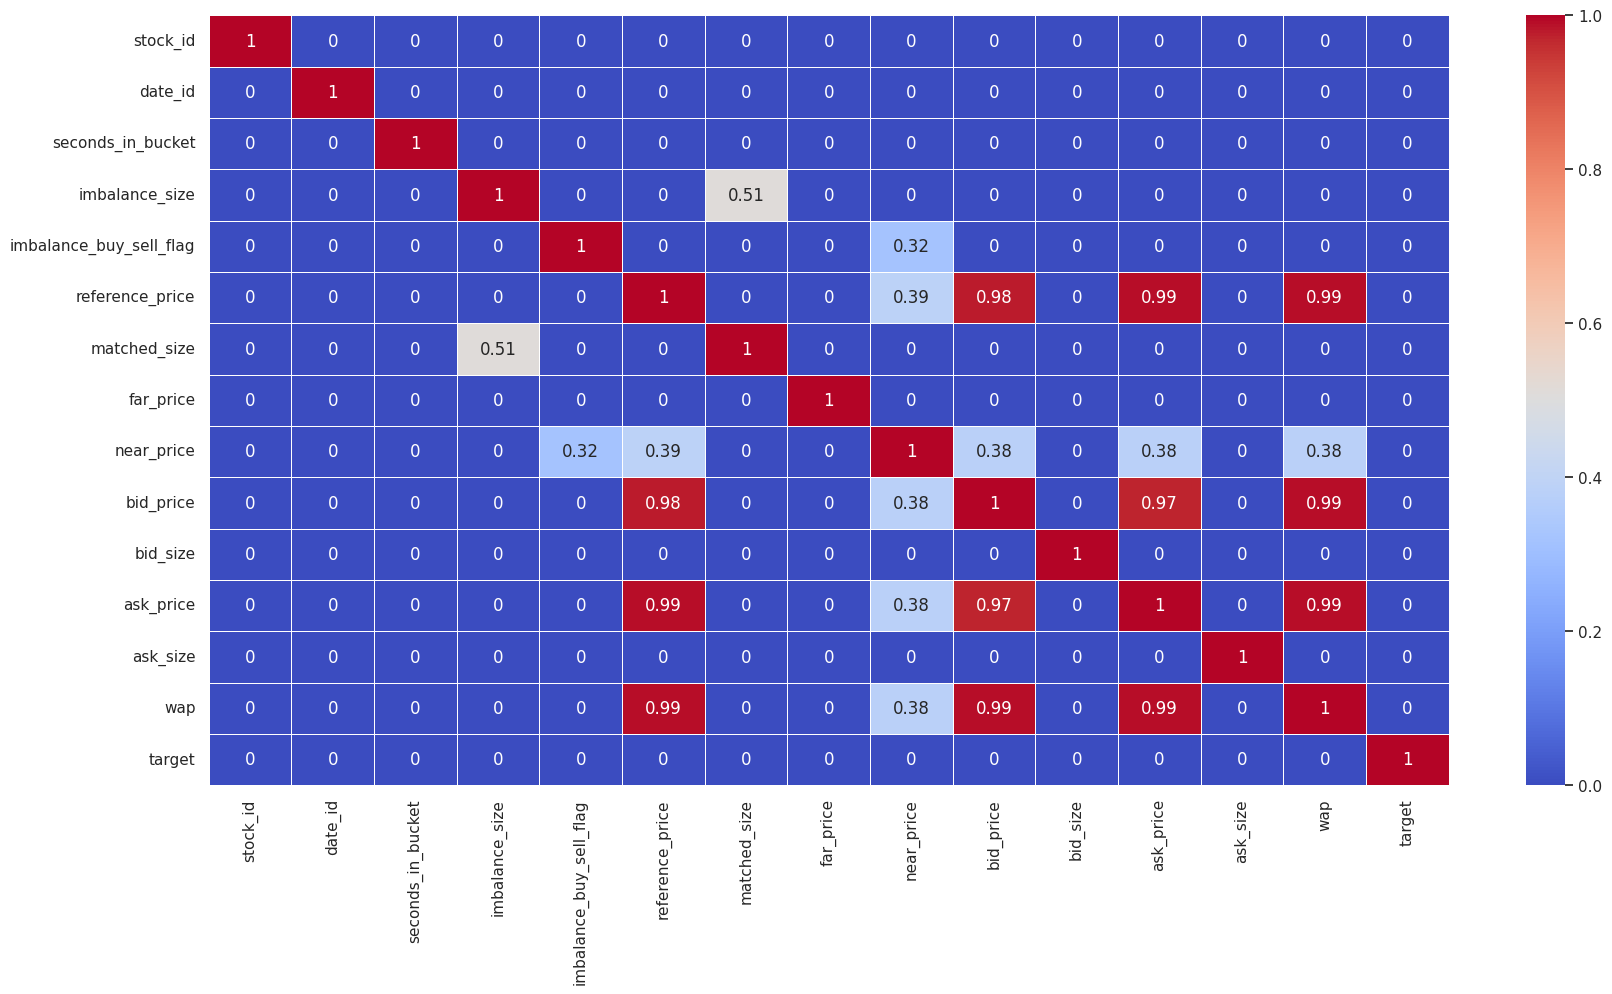

In [23]:
plt.figure(figsize=(20,10))
sns.set(font_scale=1)
corr_matrix=train.corr()
corr_matrix=np.round(corr_matrix,2)
corr_matrix[np.abs(corr_matrix)<0.3]=0
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')
plt.show()

array([[<Axes: title={'center': 'stock_id'}>,
        <Axes: title={'center': 'date_id'}>,
        <Axes: title={'center': 'seconds_in_bucket'}>,
        <Axes: title={'center': 'imbalance_size'}>],
       [<Axes: title={'center': 'imbalance_buy_sell_flag'}>,
        <Axes: title={'center': 'reference_price'}>,
        <Axes: title={'center': 'matched_size'}>,
        <Axes: title={'center': 'far_price'}>],
       [<Axes: title={'center': 'near_price'}>,
        <Axes: title={'center': 'bid_price'}>,
        <Axes: title={'center': 'bid_size'}>,
        <Axes: title={'center': 'ask_price'}>],
       [<Axes: title={'center': 'ask_size'}>,
        <Axes: title={'center': 'wap'}>,
        <Axes: title={'center': 'target'}>, <Axes: >]], dtype=object)

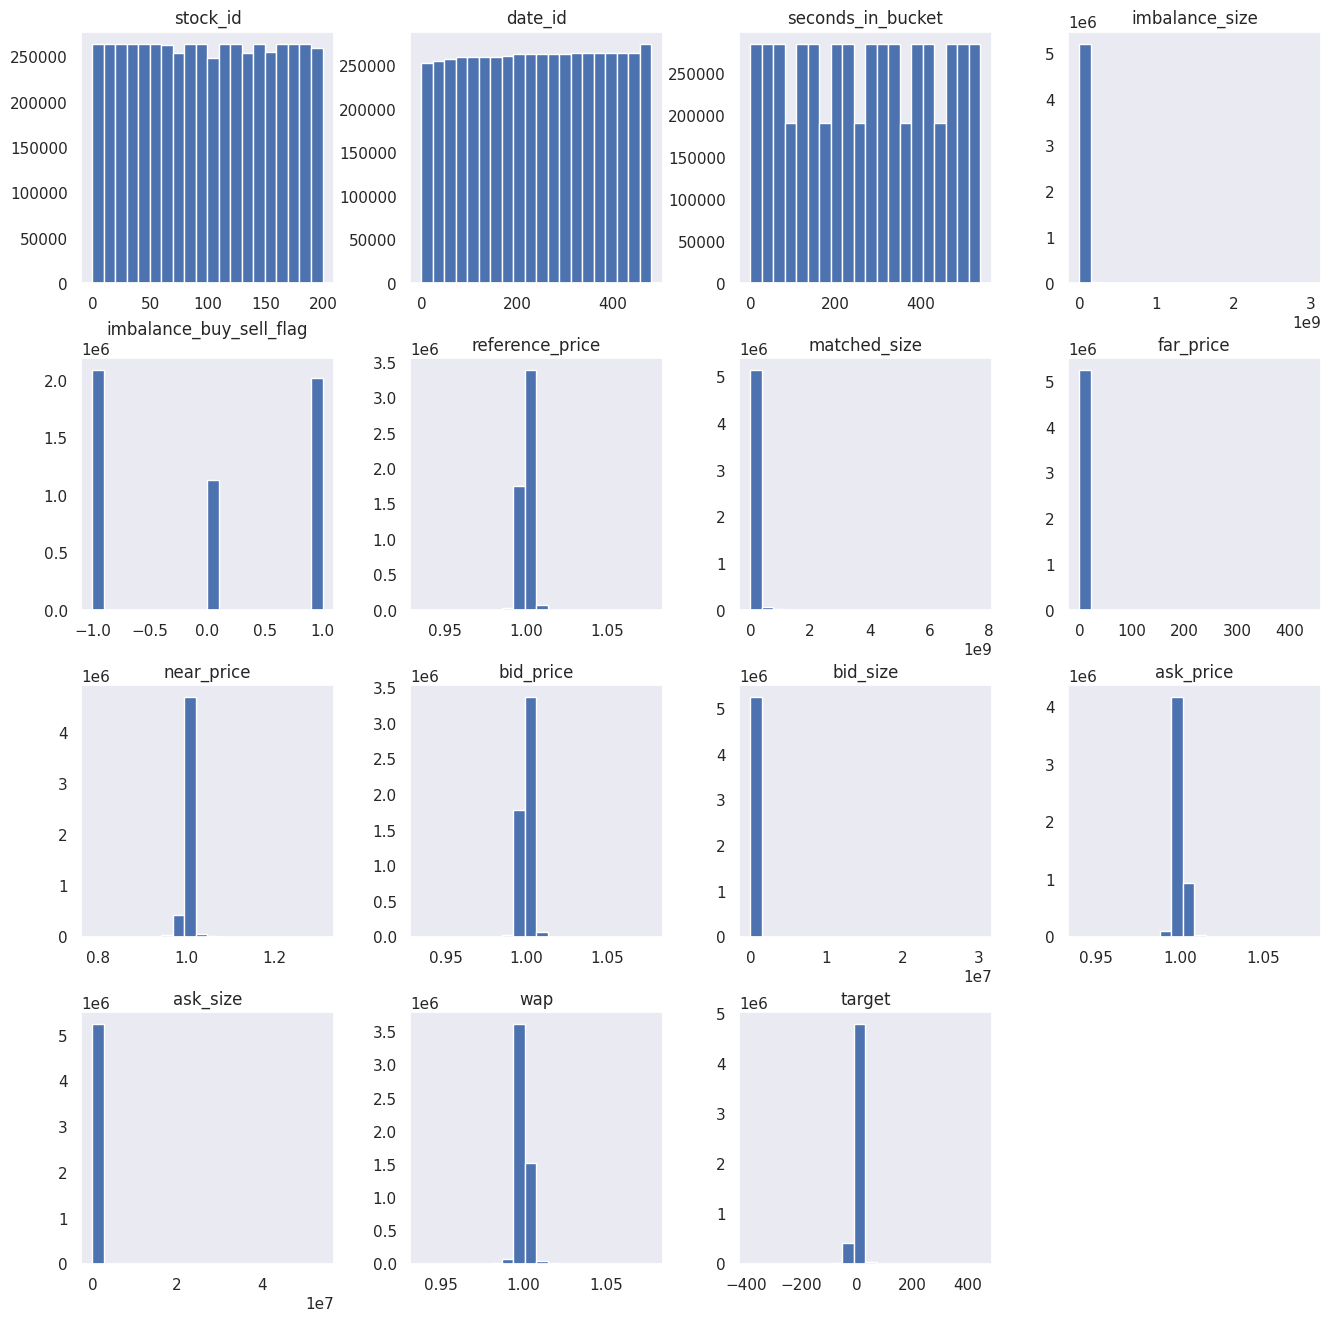

In [24]:
train.hist(figsize=(16,16), bins=20, grid=False)

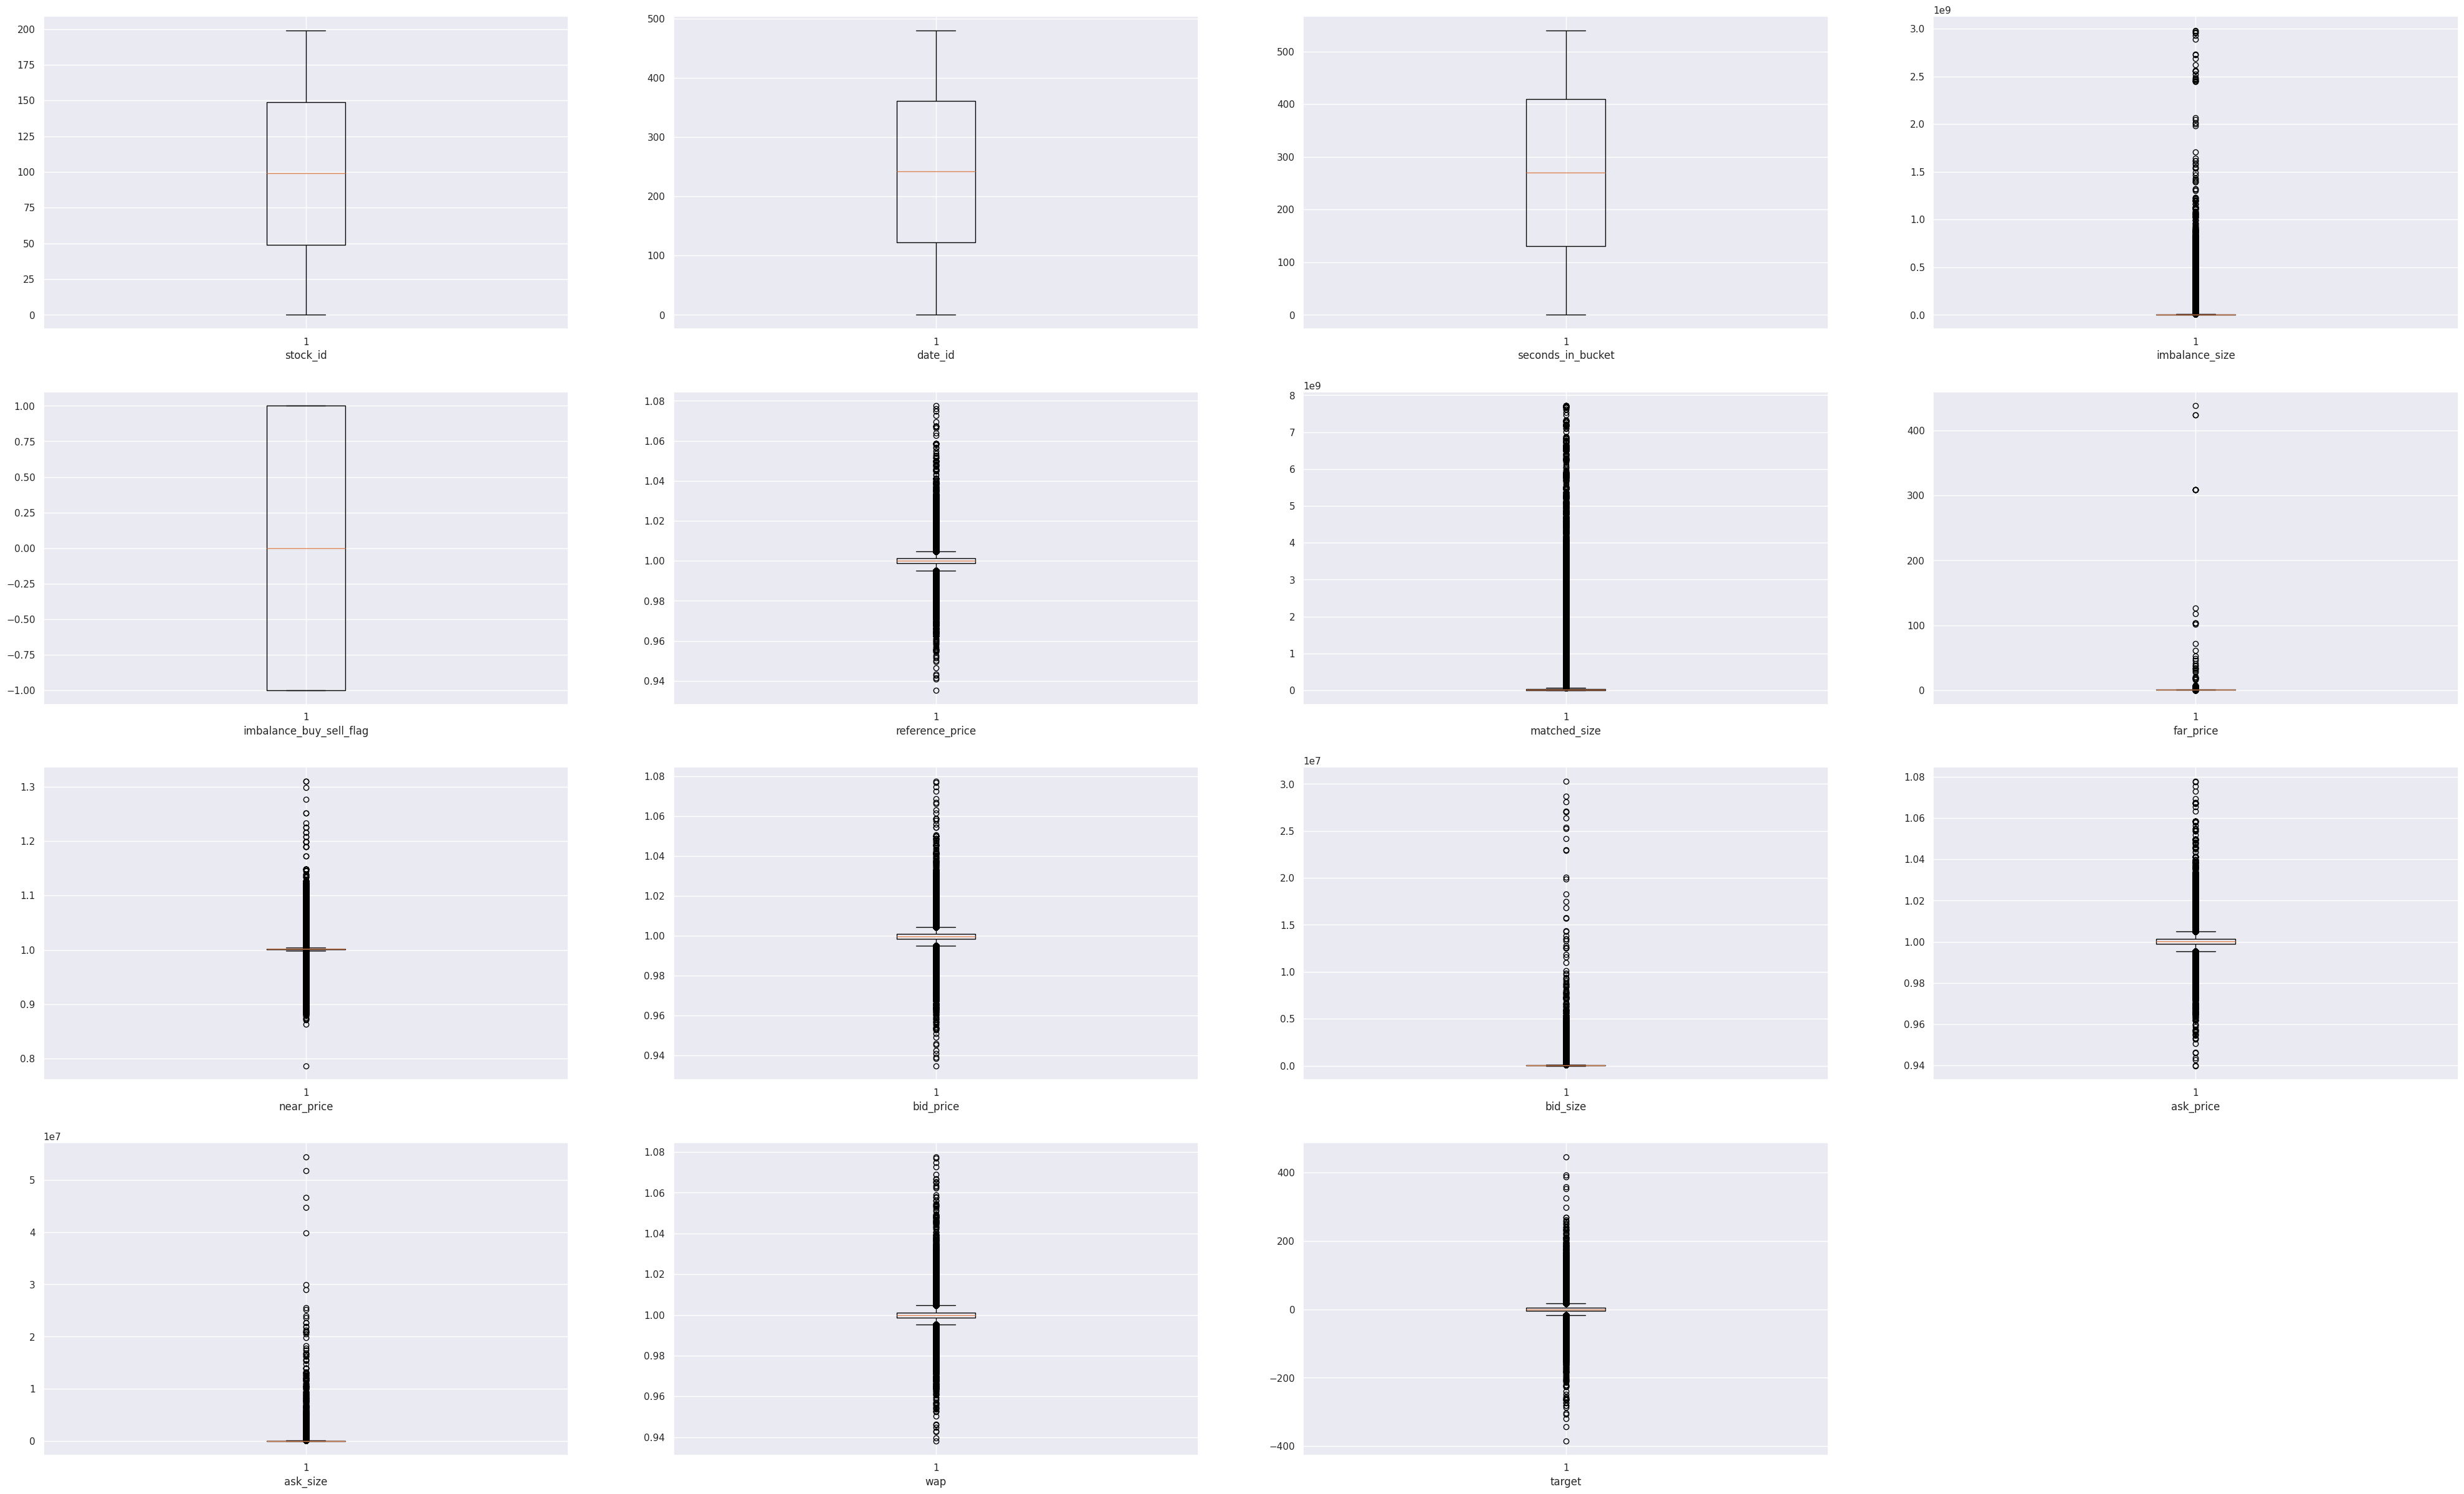

In [25]:
gs = gridspec.GridSpec(4, 4)
plt.figure(figsize=(50,30))

column=0
for i in range(4):
    column_curr=column
    for z in range(4):
        if column_curr <len(train.columns):
            ax = plt.subplot(gs[i, z])
            ax.boxplot(train[train.columns[column_curr]])
            ax.set_xlabel(train.columns[column_curr])
            column_curr+=1
            column=column_curr
column+=4

plt.show()

In [26]:
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy='constant', fill_value=-999)

In [27]:
# column_to_impute_train=[]
# for i in range(len(zero.index)):
#     column_to_impute_train.append(zero.index[i])
# for col in column_to_impute_train:
#     imputed_column = imputer.fit_transform(train[[col]])
#     train[[col]] = imputed_column

In [28]:
nonnumeric_features=['stock_id','date_id','imbalance_buy_sell_flag']
numeric_features=[]
for col in train.columns:
    if col not in nonnumeric_features:
        numeric_features.append(col)

In [29]:
for col in nonnumeric_features:
    train[col]=train[col].astype('category')

In [30]:
for col in numeric_features:
    train[col]=train[col].astype(str)

In [31]:
y=train['target'].to_numpy()
train.drop(columns=['target'], inplace=True)

In [32]:
# train=train.astype(float)

In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5237892 entries, 0 to 5237979
Data columns (total 14 columns):
 #   Column                   Dtype   
---  ------                   -----   
 0   stock_id                 category
 1   date_id                  category
 2   seconds_in_bucket        object  
 3   imbalance_size           object  
 4   imbalance_buy_sell_flag  category
 5   reference_price          object  
 6   matched_size             object  
 7   far_price                object  
 8   near_price               object  
 9   bid_price                object  
 10  bid_size                 object  
 11  ask_price                object  
 12  ask_size                 object  
 13  wap                      object  
dtypes: category(3), object(11)
memory usage: 633.5+ MB


In [23]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test=train_test_split(train,y, test_size=0.2, random_state=2)

In [24]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4190313, 14), (4190313,), (1047579, 14), (1047579,))

In [26]:
import catboost as cb
train_dataset=cb.Pool(x_train, y_train, cat_features=nonnumeric_features)
test_dataset=cb.Pool(x_test, y_test, cat_features=nonnumeric_features)

In [28]:
CAT=cb.CatBoostRegressor(metric_period=1000,
                         eval_metric='MAE',
                         task_type='GPU',
                         iterations=10000, 
                         learning_rate=0.5,
                         early_stopping_rounds = 50,
                         depth=8,
                         
                         
                        )
history=CAT.fit(train_dataset,
        eval_set=test_dataset
)

0:	learn: 6.3665021	test: 6.3558862	best: 6.3558862 (0)	total: 900ms	remaining: 2h 30m 2s


: 